In [4]:
import requests
import numpy as np
from config import *
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import os
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False


In [216]:
def df_plotting(df, title='Insert Title'):

    column_idx = df.columns.to_list()
    time_idx = df.index.to_list()

    plt.figure(figsize=(14,8))
    
    for i in column_idx:
        plt.plot(time_idx, df[i], label=i)

    plt.title(title, size=30)
    plt.legend()
    plt.show()

In [281]:
def daily_news_df():
    
    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_day = """
    {
    "size": 0,
    "aggs": {
        "group_by_date":{
        "date_histogram": {
            "field": "created_at",
            "interval": "day"
        }
        }
    }
    }
    """

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=query_day,
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    daily = data['aggregations']['group_by_date']['buckets']
    df_daily = pd.DataFrame(data = daily)[['key_as_string', 'doc_count']]
    df_daily = df_daily.rename(columns={"key_as_string" : "date"})
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_daily = df_daily.set_index('date')

    return df_daily

In [283]:
df = daily_news_df()

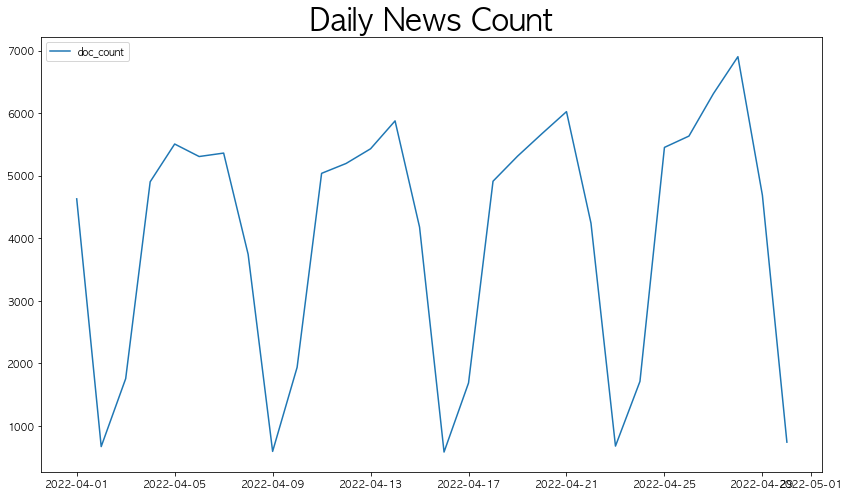

In [284]:
df_plotting(df, "Daily News Count")

# 2. Top5 언론사 리스트 변수로 받아 각 날짜 별로 언론사 기사 갯수 time-series chart 출력

## Top5 언론사

In [285]:
def top_publisher(num_of_publisher):
    
    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_publisher = """
    {
    "size": 0,
    "aggs": {
        "group_by_publisher":{
        "terms": {
            "field": "publisher.keyword",
            "size": %i
        }
        }
    }
    }
    """%int(num_of_publisher)

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=query_publisher,
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    dict = data['aggregations']['group_by_publisher']['buckets']

    df = pd.DataFrame(data=dict)

    # publisher_list = []
    # for i in range(len(dict)):
    #     publisher_list.append(dict[i]['key'])

    return df['key'].to_list()

In [286]:
top_publisher(5)

['연합뉴스', '뉴스1', '뉴시스', '이데일리', '파이낸셜뉴스']

In [287]:
def publisher_daily_news_trend (publisher_list):

    time_idx = daily_news_df().index.to_list()

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in publisher_list:
        query = """
            {
                "size": 0,
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "publisher": "%s"
                    }
                }
            }
        """ %str(keyword)

        resp = requests.get(
            url,
            data=query.encode('utf-8'),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']


    return df
    

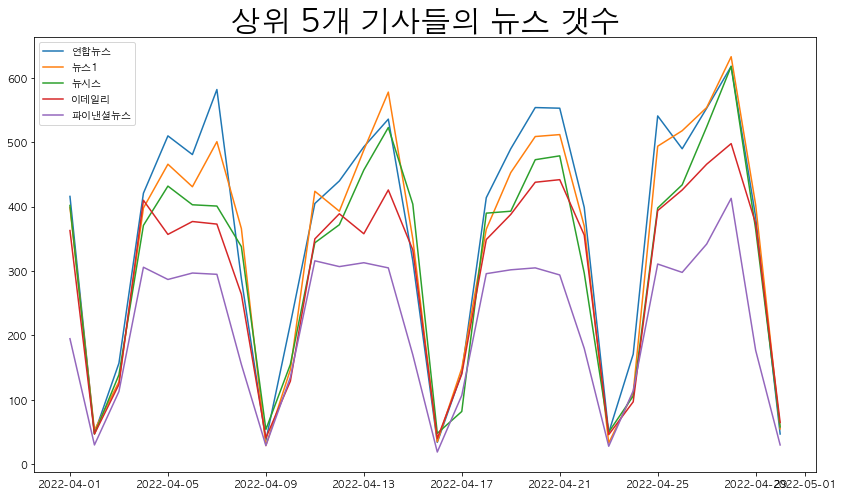

In [288]:
df_plotting(publisher_daily_news_trend(top_publisher(5)), "상위 5개 기사들의 뉴스 갯수")

In [289]:
publisher_daily_news_trend(top_publisher(5))

,연합뉴스,뉴스1,뉴시스,이데일리,파이낸셜뉴스
2022-04-01 00:00:00+00:00,416,399,402,363,195
2022-04-02 00:00:00+00:00,48,53,47,47,30
2022-04-03 00:00:00+00:00,157,128,139,124,113
2022-04-04 00:00:00+00:00,421,398,371,410,306
2022-04-05 00:00:00+00:00,510,466,432,357,287
2022-04-06 00:00:00+00:00,481,431,403,377,297
2022-04-07 00:00:00+00:00,582,501,401,373,295
2022-04-08 00:00:00+00:00,288,366,338,264,155
2022-04-09 00:00:00+00:00,37,29,54,41,29
2022-04-10 00:00:00+00:00,218,147,155,129,135


# 3. 키워드 리스트를 변수로 받아 키워드별 일별 기사 갯수 & 비율 출력

In [290]:
def keyword_daily_news_trend (keyword_list):

    time_idx = daily_news_df().index.to_list()

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in keyword_list:
        query = """
            {
                "size": 0,
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "body": "%s"
                    }
                }
            }
        """ %str(keyword)

        resp = requests.get(
            url,
            data=query.encode('utf-8'),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']

    
    df = df.fillna(0)

    return df
    

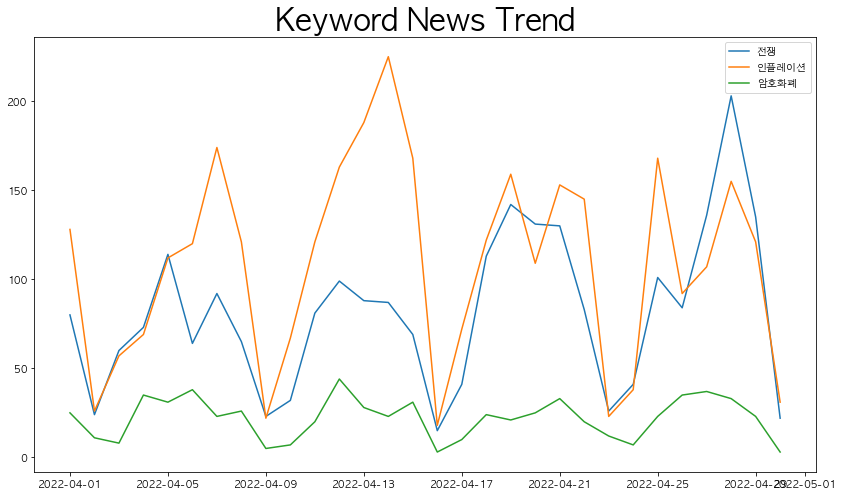

In [291]:
df_plotting(keyword_daily_news_trend(['전쟁', '인플레이션', '암호화폐']), "Keyword News Trend")

# 4. 날짜별로 뉴스 Title 크롤링해서 리스트로 정리

In [292]:
import os
import pdb
import datetime as dt
import requests
import json
import pandas as pd

from config import *
from dateutil.relativedelta import relativedelta
from docopt import docopt #해당 모듈을 어떻게 쓸지 자동으로 알려 줌

def fetch_news_docs(date_from, date_to, page):
    
    query = {
        "query": {
            "range":{
                "created_at": {
                    "gte": date_from.isoformat(),
                    "lt": date_to.isoformat()
                }
            }
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_titles(hits):

    return hits['_source']['title']

def download_total_title (date_from, date_to):

    date_interval = list(pd.date_range(dt.datetime.strptime(date_from, '%Y-%m-%d'), dt.datetime.strptime(date_to, '%Y-%m-%d'), freq='d'))

    print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs(start_date, end_date, page)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        print("***" + str_date + "End!" + "***")

    print("Daily Data end!")

    return total_title_list

def total_title_show (total_title_list, date_from, date_to):

    date_interval = list(pd.date_range(dt.datetime.strptime(date_from, '%Y-%m-%d'), dt.datetime.strptime(date_to, '%Y-%m-%d'), freq='d'))  

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(str_date)
        print(total_title_list[i] + '\n')

    #return date_interval

def txt_title_save (total_title_list, date_from, date_to):

    date_interval = list(pd.date_range(dt.datetime.strptime(date_from, '%Y-%m-%d'), dt.datetime.strptime(date_to, '%Y-%m-%d'), freq='d'))  

    with open('title_list_allday.txt','w',encoding='UTF-8') as f:

        for i in range(len(total_title_list)):
        
            str_date = date_interval[i].strftime('%Y-%m-%d')

            f.write('\n' + '[' + str_date + ']' + '\n\n')
        
            for titles in total_title_list[i]:

                f.write(titles + '\n')

In [68]:
# daily_news_title = download_total_title('2022-04-01', '2022-04-30')

2022-04-01 Start!
***2022-04-01End!***
2022-04-02 Start!
***2022-04-02End!***
2022-04-03 Start!
***2022-04-03End!***
2022-04-04 Start!
***2022-04-04End!***
2022-04-05 Start!
***2022-04-05End!***
2022-04-06 Start!
***2022-04-06End!***
2022-04-07 Start!
***2022-04-07End!***
2022-04-08 Start!
***2022-04-08End!***
2022-04-09 Start!
***2022-04-09End!***
2022-04-10 Start!
***2022-04-10End!***
2022-04-11 Start!
***2022-04-11End!***
2022-04-12 Start!
***2022-04-12End!***
2022-04-13 Start!
***2022-04-13End!***
2022-04-14 Start!
***2022-04-14End!***
2022-04-15 Start!
***2022-04-15End!***
2022-04-16 Start!
***2022-04-16End!***
2022-04-17 Start!
***2022-04-17End!***
2022-04-18 Start!
***2022-04-18End!***
2022-04-19 Start!
***2022-04-19End!***
2022-04-20 Start!
***2022-04-20End!***
2022-04-21 Start!
***2022-04-21End!***
2022-04-22 Start!
***2022-04-22End!***
2022-04-23 Start!
***2022-04-23End!***
2022-04-24 Start!
***2022-04-24End!***
2022-04-25 Start!
***2022-04-25End!***
2022-04-26 Start!
***2022

In [69]:
# daily_news_title[1][0:10]

['제1009회 로또 1등 15명… 17억원씩 당첨',
 '충청북도 “일자리 11만 개, 고용률 73% 목표”',
 '남양주 친환경시설 에코랜드 도랑에 개구리 떼죽음',
 '‘추억의 SNS’ 싸이월드 2년6개월만에 서비스 재개…설치·접속 오류도',
 '휘발윳값 10주 연속 상승 끝에 찔끔 하락, 소비자물가 4% 넘을까?',
 "화성 분양시장 열기…'화성비봉 예미지 센트럴에듀' 공급",
 "마켓컬리의 '공헌 이익' 상장에도 공헌할까",
 '유실수 구제역 \'과수화상병\'…"적기에 방제해야"',
 '해남군, 유해야생동물 피해 예방시설 설치 지원',
 '10주 연속 상승 휘발유값 소폭 하락']

In [70]:
# txt_title_save(daily_news_title, '2022-04-01', '2022-04-30')

# 각 날짜별로 주요 이슈 Top 3 요약

In [275]:
import nltk
import datetime as dt
import pdb

from collections import defaultdict
from sklearn.pipeline import Pipeline

from es_corpus_reader import EsCorpusReader
from korean_text_normalizer import KoreanTextNormalizer
from gensim_vectorizer import GensimTfidVectorizer
    
def classification_top_n(count_dict, n=3):
    
    for group in range(len(count_dict)):
        count_dict[group].sort()

    top_n = dict(sorted(count_dict.items(), reverse=True, key=lambda x: len(x[1]))[:n])

    i = 1

    for key in top_n.keys():
    
        print(f"*** TOP {i} Section ***")
        
        for idx, content in enumerate(top_n[key]):
            
            if idx < 5:
                print(f"{content}")
            else:
                pass
        i += 1

def daily_k_means_top3(date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = daily_news_df()

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader(date_from=time)

        doc_num = total_doc_count.loc[time]['doc_count']
 
        corpus = list(reader.titles(n=doc_num))


        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 20
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f"-------- {str_time}'s TOP 3 ISSUES --------")
        classification_top_n(classified, n=3)
        print("\n")
        
        # for group in range(len(classified)):
        #     print(f'*** Group {group} ***')

        #     classified[group].sort() #작은거에서 큰걸로 그룹안에 점수 정렬함 (양극단값이 아래로 내려가고 중앙값이 가운데로 올라옴)

        #     print("Topic Size: {}".format(len(classified[group])))

        #     for idx, x in enumerate(classified[group]):
        #         print(f'{idx}: {x}')

        #         if idx > 5:
        #             break

        #     print()

    # return classified



In [277]:
daily_k_means_top3('2022-04-01', '2022-04-30')

-------- 2022-04-01's TOP 3 ISSUES --------
*** TOP 1 Section ***
(0.7284947441921292, '또 오른 기준금리…불어나는 이자, 멀어지는 내 집 마련')
(0.7765348010407334, '[금융 인사이드] 부실금융기관 가능성 커지는 MG손보…짙어지는 매각 그림자')
(0.779897849730496, '절반 수준으로 떨어진 대게 가격')
(0.779897849730496, '절반 수준으로 떨어진 대게 가격')
(0.783276314780984, '[생생경제] 엔데믹이 가져올 경제 효과는?')
*** TOP 2 Section ***
(0.6297935190488229, '신규확진 12만5846명, 거리두기 전면 해제 앞두고 감소세 이어져')
(0.6325381128819836, '거리두기 해제한 정부, 스포츠·숙박 할인 행사 추진')
(0.6562343162834756, '거리두기 해제, 증시 영향은')
(0.6917092201467039, '스페인, 반도체 산업에 15조 원 투자…“곧 정부 승인 나올 것”')
(0.6957654851522717, '“거리두기 해제로 소비 회복 재개될 것…금리 인상은 가계 부담”')
*** TOP 3 Section ***
(0.4629909755386965, '3월 소비자물가 4.1%↑…유류세 30%로 추가 인하')
(0.4770549672208019, '3월 소비자물가 4.1%↑…10년 3개월 만에 4%대로')
(0.48250460818721874, '3월 소비자물가 4.1% 올라, 10년 3개월 만에 4% 넘어서')
(0.48250460818721874, '3월 소비자물가 4.1% 올라, 10년 3개월 만에 4% 넘어서')
(0.4901116112494812, '[속보] 3월 소비자물가 4.1% 상승…10년 만에 최대')


-------- 2022-04-02's TOP 3 ISSUES --------
*** TOP 1 Section ***
(0.823685

# 키워드 날짜 별로 주요 이슈 요약

In [293]:
def daily_k_means_top3(date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = daily_news_df()

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader(date_from=time)

        doc_num = total_doc_count.loc[time]['doc_count']
 
        corpus = list(reader.titles(n=doc_num))


        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 20
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f"-------- {str_time}'s TOP 3 ISSUES --------")
        classification_top_n(classified, n=3)
        print("\n")

In [278]:
def fetch_news_docs_with_keyword (date_from, date_to, page, keyword):
    
    query = {
        "query": {
            "bool": {
                "must":[
                    {
                        "match":{
                            "body": keyword
                        }
                    },
                {
                    "range":{
                        "created_at": {
                            "gte": date_from.isoformat(),
                            "lt": date_to.isoformat()
                            }
                        }
                    }
                ]
            },
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

In [280]:
fetch_news_docs_with_keyword(dt.datetime(2022, 4, 1), dt.datetime(2022, 4, 2), 10, "인플레이션")

[{'_index': 'news',
  '_type': '_doc',
  '_id': '009-0004943767',
  '_score': 3.9208546,
  '_source': {'title': '1분기 코스피, 보험·건설·항공株 날았다',
   'section': 'economy',
   'naver_url': 'https://n.news.naver.com/mnews/article/009/0004943767?sid=101',
   'source_url': 'http://news.mk.co.kr/newsRead.php?no=296169&year=2022',
   'image_urls': ['https://imgnews.pstatic.net/image/009/2022/04/01/0004943767_001_20220401195201051.jpg?type=w647'],
   'publisher': '매일경제',
   'created_at': '2022-04-01T17:46:02',
   'updated_at': '2022-04-01T19:52:01',
   'reporter_name': '차창희',
   'reporter_email': 'charming91@mk.co.kr',
   'body': "금리인상기 대표 수혜주\n메리츠화재 36% 상승\n주택 250만가구 공급 호재\n대우건설·GS건설도 올라\n저비용항공사도 수급 개선\n게임·2차전지株는 큰폭 하락\n올해 1분기 국내 증시의 승자는 실적·정책 모멘텀을 등에 업은 보험·건설·항공주였다. 반면 게임주와 2차전지(배터리) 소재주는 실적 불확실성으로 부진을 면치 못했다.\n1일 금융정보 업체 에프앤가이드에 따르면 시가총액 5000억원 이상 상장사 가운데 올해 초부터 지난 3월까지 주가 상승률이 가장 돋보이는 업종은 보험이었다. 보험주 선두 주자는 메리츠화재로 해당 기간에 주가가 36.07% 상승했다. 자사주 취득과 소각으로 주주가치 제고에 앞장서고 있는 메리츠화재는 지난 2월에도 1000억원 규모 자기주식 취

# My Portfolio